In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, zero_one_loss  # evaluation metrics

In [2]:
FMIRawData = pd.read_excel("data.xlsx")

# sanity check the shape of FMIRawData
assert FMIRawData.shape == (387,10)

# print the first 5 rows of the DataFrame 'FMIRawData'
FMIRawData.head(5) 

,time,time format,minute,second,total,within pity,4* counter,4* drop rate,5* drop rate,rarity
0,2021-08-10 22:47:48,22:47:48,47,48,1,1,1,0.051,0.006,3
1,2021-08-10 22:47:48,22:47:48,47,48,2,2,2,0.051,0.006,3
2,2021-08-10 22:47:48,22:47:48,47,48,3,3,3,0.051,0.006,3
3,2021-08-10 22:47:48,22:47:48,47,48,4,4,4,0.051,0.006,3
4,2021-08-10 22:47:48,22:47:48,47,48,5,5,5,0.051,0.006,3


In [3]:
#check the columns in the data
FMIRawData.columns

Index(['time', 'time format', 'minute', 'second', 'total', 'within pity',
       '4* counter', '4* drop rate', '5* drop rate', 'rarity'],
      dtype='object')

In [4]:
#remove unnecessary columns
data = FMIRawData.drop(['time','time format','total','4* counter','within pity'], axis=1)

data.head(5) 

,minute,second,4* drop rate,5* drop rate,rarity
0,47,48,0.051,0.006,3
1,47,48,0.051,0.006,3
2,47,48,0.051,0.006,3
3,47,48,0.051,0.006,3
4,47,48,0.051,0.006,3


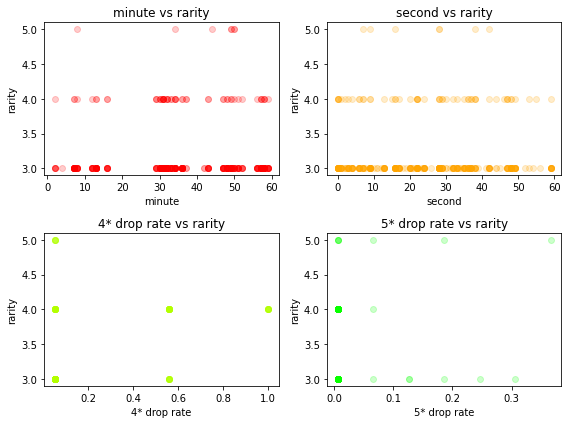

In [5]:
#Separate scatter plots between one feature to the label 'rarity' 
#The darker the dots, the denser the population is/

jet= plt.get_cmap('hsv')
colors = iter(jet(np.linspace(0,1,10)))

 
def correlation(df,variables, n_rows, n_cols):
    fig = plt.figure(figsize=(8,6))
    
    for i, var in enumerate(variables):        
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = df.loc[:,var]
        ax.scatter(asset, df["rarity"], color = next(colors), alpha=0.2)
        ax.set_ylabel("rarity")
        ax.set_xlabel("{}".format(var))
        ax.set_title(var +" vs rarity")
    fig.tight_layout() 
    plt.show()
        
# variables contain the names of the columns of 4 features
variables = data.columns[0:4]  
 
correlation(data,variables,2,2)

In [6]:
#calculate correlation between different features to the label 'rarity'
data.corr()['rarity'].loc[variables]

minute          0.029049
second          0.022555
4* drop rate    0.490784
5* drop rate    0.186709
Name: rarity, dtype: float64

In [7]:
#We will use logistic regression for the dataset

#label 0 means wishes that don't result in a rarity-4 or rarity-5 items.
#label 1 means wishes that result in a rarity 4 or 5

bi_labels = [0,1]
bi_cut_bins = [0,3,6]
binarized_rarity = pd.cut(data['rarity'],\
                          bins=bi_cut_bins, labels = bi_labels, include_lowest = True)

data.insert(5, 'binarized rarity', binarized_rarity)
data.head(10)

,minute,second,4* drop rate,5* drop rate,rarity,binarized rarity
0,47,48,0.051,0.006,3,0
1,47,48,0.051,0.006,3,0
2,47,48,0.051,0.006,3,0
3,47,48,0.051,0.006,3,0
4,47,48,0.051,0.006,3,0
5,47,48,0.051,0.006,3,0
6,47,48,0.051,0.006,3,0
7,47,48,0.051,0.006,3,0
8,47,48,0.561,0.006,3,0
9,47,48,1.000,0.006,4,1


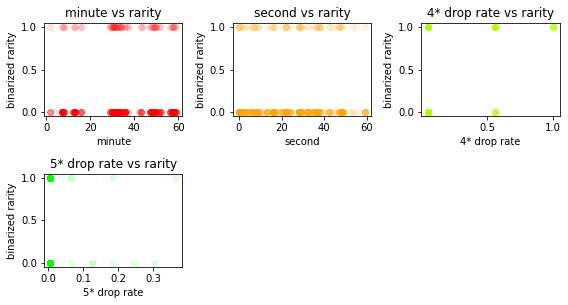

In [8]:
#visualize the data but with binarized rarity instead

jet= plt.get_cmap('hsv')
colors = iter(jet(np.linspace(0,1,10)))

 
def correlation(df,variables, n_rows, n_cols):
    fig = plt.figure(figsize=(8,6))
    
    for i, var in enumerate(variables):        
        ax = fig.add_subplot(n_rows,n_cols,i+1)
        asset = df.loc[:,var]
        ax.scatter(asset,df["binarized rarity"], color = next(colors), alpha=0.1)
        ax.set_ylabel("binarized rarity")
        ax.set_xlabel("{}".format(var))
        ax.set_title(var +" vs rarity")
    fig.tight_layout() 
    plt.show()
        
# variables contain the names of the columns of 4 features
variables = data.columns[0:4]  
 
correlation(data,variables,3,3)

In [9]:
# Some observations from the above figures
# 1. Better rarity happens approximately in the last 30 minutes of an hour and in the first 40 seconds of a minute
# i.e. from (mm:ss) 31:00  until 31:40, then 31:00 until 31:40, etc 
# 2. Higher drop rates do not guarantee better rarity

In [10]:
#X is a list of features
X = data.values[:,0:4]
#label rarity
y = data['binarized rarity'].to_numpy()


In [11]:
#SPLIT THE DATASET
#60% of the dataset is used for model training
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4, random_state=42)

#50% of the remaining dataset is used for model testing, the rest is used for validation
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)


In [12]:
#Apply Logistic regression for the train and validation set
start = time.time()
clf = LogisticRegression(C=100000)  
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

y_pred_val = clf.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)
stop = time.time()
clf_report= classification_report(y_pred_val, y_val)
print("accuracy of the train set: ", acc_train)
print("accuracy of the validation set: ", acc_val)
print(f"Time to performed logistic regression: {stop-start}s")
print(clf_report)



accuracy of the train set:  0.8706896551724138
accuracy of the validation set:  0.922077922077922
Time to performed logistic regression: 0.049822092056274414s
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        70
           1       0.57      0.57      0.57         7

    accuracy                           0.92        77
   macro avg       0.76      0.76      0.76        77
weighted avg       0.92      0.92      0.92        77



In [13]:
# Apply SVC for the train and validation set
startSVC = time.time()
clf1 = SVC(kernel="linear", C=100000)
clf1.fit(X_train, y_train)

y_pred_train_SVC = clf1.predict(X_train)
acc_train_SVC = accuracy_score(y_train, y_pred_train_SVC)

y_pred_val_SVC = clf1.predict(X_val)
acc_val_SVC = accuracy_score(y_val, y_pred_val_SVC)
stopSVC = time.time()
clf_report= classification_report(y_pred_val_SVC, y_val)
print("accuracy of the train set using SVC: ", acc_train_SVC)
print("accuracy of the validation set using SVC: ", acc_val_SVC)
print(f"Time to performed SVC: {stopSVC-startSVC}s")
print(clf_report)


accuracy of the train set using SVC:  0.8318965517241379
accuracy of the validation set using SVC:  0.8961038961038961
Time to performed SVC: 80.63414716720581s
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        70
           1       0.43      0.43      0.43         7

    accuracy                           0.90        77
   macro avg       0.69      0.69      0.69        77
weighted avg       0.90      0.90      0.90        77



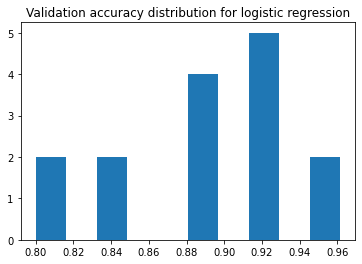

In [14]:
# Use KFold for Logistic regression, n_splits = 15
cv = KFold(n_splits=15, random_state=43, shuffle=True)
validation_accuracy = []
for train_index, val_index in cv.split(y):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    clf = LogisticRegression(C=100000)  
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    
    validation_accuracy.append(acc_val)

plt.hist(validation_accuracy)
plt.title("Validation accuracy distribution for logistic regression")
plt.show() 

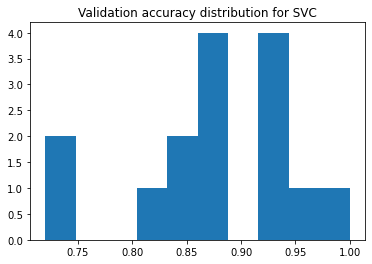

In [15]:
# Use KFold for SVC, n_splits = 15
cv1 = KFold(n_splits=15, random_state=43, shuffle=True)
validation_accuracy = []
for train_index, val_index in cv1.split(y):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    clf = SVC(kernel="linear",C=100000)  
    clf.fit(X_train, y_train)
    y_pred_val = clf.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    
    validation_accuracy.append(acc_val)

plt.hist(validation_accuracy)
plt.title("Validation accuracy distribution for SVC")
plt.show() 

In [16]:
# Perform accuracy calculation on the test set for Logistic Regression

y_pred_test = clf.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
print("accuracy of the test set: ", acc_test)


accuracy of the test set:  0.9358974358974359
